# CRF (and NN) for Named Entity Recognition

### Based on https://github.com/aminaghoul/NER-PyTorch

In this notebook we use conditional random fields (CRFs) which are generally used for named entity recognition in order to predict valid sequences.
For example, one should not have a `B-PER` followed directly by another `B-PER`.

For the CRF implementation, we will use the package [pytorch-crf](https://github.com/kmkurn/pytorch-crf).

In [1]:
!pip install torchtext==0.6.0 pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import time
import torch
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Data preparation

In [3]:
!mkdir data_ner

mkdir: cannot create directory ‘data_ner’: File exists


In [5]:
!wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/train.csv && mv train.csv data_ner/

--2023-03-17 03:29:03--  https://github.com/aminaghoul/NER-PyTorch/raw/master/data/train.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/train.csv [following]
--2023-03-17 03:29:04--  https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1666337 (1.6M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   1.59M  --.-KB/s    in 0.07s   

2023-03-17 03:29:05 (22.3 MB/s) - ‘train.csv’ saved [1666337/1666337]



In [6]:
!wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/valid.csv && mv valid.csv data_ner/

--2023-03-17 03:30:07--  https://github.com/aminaghoul/NER-PyTorch/raw/master/data/valid.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/valid.csv [following]
--2023-03-17 03:30:08--  https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/valid.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419999 (410K) [text/plain]
Saving to: ‘valid.csv’

valid.csv           100%[===================>] 410.16K  --.-KB/s    in 0.04s   

2023-03-17 03:30:08 (9.40 MB/s) - ‘valid.csv’ saved [419999/419999]



In [7]:
!wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/test.csv && mv test.csv data_ner/

--2023-03-17 03:30:32--  https://github.com/aminaghoul/NER-PyTorch/raw/master/data/test.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/test.csv [following]
--2023-03-17 03:30:33--  https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378113 (369K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>] 369.25K  --.-KB/s    in 0.04s   

2023-03-17 03:30:33 (8.91 MB/s) - ‘test.csv’ saved [378113/378113]



In [4]:
# for the sake of reproducubility
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
TEXT = data.Field(lower = False) 
TAG = data.Field(unk_token = None) # all the tags are known thus we set unk_token = None

my_path = "data_ner/"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", TEXT), ("tag", TAG))
    )
MIN_FREQ = 0

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # the words with frequency less than MIN_FREQ will be ignored and do not appear in the vocabulary
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# padding index
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

# Building the model

For the model class, there are three main features:

1. Prepare the CRF layer during initialization. We need to specify the number of possible tags in the text.
2. include the logic of the CRF layer in the sequence `forward()`. There is a major change in the `forward()` due to the implementation of the `pytorch-crf` package. So far, we do forward propagation and loss calculation separately. Loss calculations are now integrated with forward propagation.
3. Initialize all impossible transitions with a really low number (-100) in the `init_crf_transitions` function. This is where we impose the BIO sequence logic on the model.

In [14]:
class NNCRF(nn.Module):
    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 emb_dropout,
                 fc_dropout,
                 word_pad_idx,
                 tag_pad_idx):
        super().__init__()
        
        # LAYER 1: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        self.emb_dropout = nn.Dropout(emb_dropout)

        # LAYER 2: Fully-connected  
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(embedding_dim, hidden_dim * 2) 
        
        # LAYER 3: Fully-connected  
        self.fc_dropout2 = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, output_dim) 

        # LAYER 4: CRF
        self.tag_pad_idx = tag_pad_idx
        self.crf = CRF(num_tags=output_dim)
        
        # init params with normal distribution
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, tags=None):
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]
        
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # fc_out = [sentence length, batch size, hidden dim * 2]
        fc_out = self.fc(self.fc_dropout(embedding_out))
        
        # fc_out2 = [sentence length, batch size, output dim]
        fc_out2 = self.fc2(self.fc_dropout2(fc_out))
      
        if tags is not None:
            mask = tags != self.tag_pad_idx
            crf_out = self.crf.decode(fc_out2, mask=mask)
            crf_loss = -self.crf(fc_out2, tags=tags, mask=mask) 
        else:
            crf_out = self.crf.decode(fc_out2)
            crf_loss = None
          
        return crf_out , crf_loss

   
  
    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and <pad> cannot be in the beginning
            if tag_name[0] == "I" or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
        # O - I transition is impossible
        tag_is = {}
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        impossible_transitions_position = {
            "O": "I"

        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                    
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # impossible transitions between different types
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [15]:
embedding_dim=100
tag_pad_idx=TAG_PAD_IDX
model = NNCRF(
    input_dim=len(TEXT.vocab),
    embedding_dim=100,
    hidden_dim=256,
    output_dim=len(TAG.vocab),
    emb_dropout=0.1,
    fc_dropout=0.1,
    word_pad_idx=TEXT_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX
)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[tag_pad_idx] = torch.zeros(embedding_dim)

# CRF transitions initialisation
model.init_crf_transitions(
    tag_names=TAG.vocab.itos
)
print(f"The model has {model.count_parameters():,} trainable parameters.")

The model has 2,419,562 trainable parameters.


We can access the transition matrix and make sure that the initialization is done as expected:

In [16]:
def print_crf_transitions(c, m):
    tags = TAG.vocab.itos
    max_len_tag = max([len(tag) for tag in tags])
    print("Start and end tag transitions:")
    print(f"{'TAG'.ljust(max_len_tag)}\tSTART\tEND")
    for tag, start_prob, end_prob in zip(tags, m.crf.start_transitions.tolist(), m.crf.end_transitions.tolist()):
        print(f"{tag.ljust(max_len_tag)}\t{round(start_prob, 2)}\t{round(end_prob, 2)}")
    print()
    print("Between tags transitions:")
    persons_i = [i for i, tag in enumerate(TAG.vocab.itos) if "PER" in tag or tag == "O"]
    max_len_tag = max([len(tag) for tag in TAG.vocab.itos if "PER" in tag ])
    transitions = m.crf.transitions
    to_tags = "TO".rjust(max_len_tag) + "\t" + "\t".join([tag.ljust(max_len_tag) for tag in tags if "PER" in tag or tag == "O"])
    print(to_tags)
    print("FROM")
    for from_tag_i, from_tag_probs in enumerate(transitions[persons_i]):
        to_tag_str = f"{tags[persons_i[from_tag_i]].ljust(max_len_tag)}"
        for to_tag_prob in from_tag_probs[persons_i]:
            to_tag_str += f"\t{str(round(to_tag_prob.item(), 2)).ljust(max_len_tag)}"
        print(to_tag_str)

print_crf_transitions(TEXT, model)

Start and end tag transitions:
TAG   	START	END
<pad> 	-100.0	-0.12
O     	-0.05	0.03
B-LOC 	-0.07	-0.02
B-PER 	0.07	0.13
B-ORG 	0.0	0.06
I-PER 	-100.0	-0.13
I-ORG 	-100.0	-0.06
B-MISC	0.04	-0.13
I-LOC 	-100.0	0.06
I-MISC	-100.0	-0.04

Between tags transitions:
   TO	O    	B-PER	I-PER
FROM
O    	0.01 	-0.04	-100.0
B-PER	-0.16	0.1  	-0.11
I-PER	0.12 	0.01 	-0.02


# Training

The outputs of the model are two lists: predictions and losses.
These changes are taken into account by modifying the function that computes the accuracy.

 - Optimizer

In [17]:
def opt(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = opt(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)

 - Metrics

In [18]:
from sklearn.metrics import f1_score, classification_report

def f1_loss( preds, y, tag_pad_idx, full_report=False):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                       if i not in (tag_pad_idx, index_o)]

    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    if full_report:
      
        positive_names = [TAG.vocab.itos[i]
                              for i in range(len(TAG.vocab.itos))
                              if i not in (tag_pad_idx, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

In [19]:
def train(model, iterator, optimizer, tag_pad_idx):
    epoch_loss = 0
    epoch_f1 = 0    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
      
        optimizer.zero_grad()

        pred_tags_list, batch_loss = model(text, tags)
        
        # to calculate loss and F1 score we flatten true tags
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        f1,_,_ = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator)

In [20]:
def evaluate(model, iterator, tag_pad_idx,full_report):
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
        
            pred_tags_list, batch_loss = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            
            f1, pred, lab = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator),preds, labels

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 1

In [23]:
t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
   
    train_loss, train_f1 = train(model, train_iterator, optimizer, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1) 
    
    valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, TAG_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)
    
    scheduler.step()
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model_conll.pt')
    

    if epoch%1 == 0: 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 19s
	Train Loss: 164.082 | Train F1 score: 14.66%
	 Val. Loss: 134.863 |  Val. F1 score: 16.52%


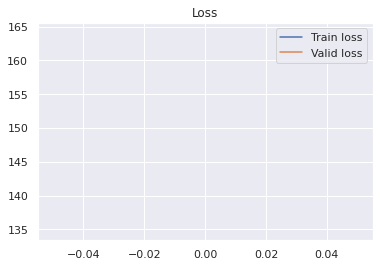

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

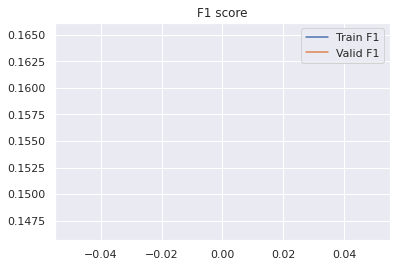

In [25]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [26]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
model.load_state_dict(torch.load('tut3-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, TAG_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 119.986 |  Test F1 score: 15.53%


In [27]:
predict =  [item for sublist in preds for item in sublist]
true =  [item for sublist in labels for item in sublist]
confusion = confusion_matrix(true, predict)

### Confusion matrix

In [28]:
confusion_df =pd.DataFrame(confusion)

confusion_df.columns=[i for i in TAG.vocab.itos]
s = pd.Series([i for i in TAG.vocab.itos])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


confusion_df = confusion_df.drop(columns=[ i for i in TAG.vocab.itos if i != 'O'])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

confusion_df = confusion_df.drop([i for i in TAG.vocab.itos if i != 'O'  ])

confusion_df

,O,LOC,PER,ORG,MISC
O,37024,405,180,486,212
LOC,859,577,136,143,72
PER,1930,174,172,196,145
ORG,1289,363,212,294,179
MISC,368,70,119,146,121


### Precision-Recall-F1Score

In [29]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    
    temp = np.delete(temp, i, 1) 
    TN.append(sum(sum(temp)))
    
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

prf_df =pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.892790,0.966507,0.928187
LOC,0.363121,0.322888,0.341825
PER,0.210012,0.065724,0.100116
ORG,0.232411,0.125802,0.163243
MISC,0.165981,0.146845,0.155827


## Inference

In [39]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])

    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.as_tensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions, _ = model(token_tensor)
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

In [40]:
example_index = 6

sentence = vars(valid_data.examples[example_index])['text']
actual_tags = vars(valid_data.examples[example_index])['tag']

print(sentence)
print(actual_tags)

['Trailing', 'by', '213', ',', 'Somerset', 'got', 'a', 'solid', 'start', 'to', 'their', 'second', 'innings', 'before', 'Simmons', 'stepped', 'in', 'to', 'bundle', 'them', 'out', 'for', '174', '.']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [41]:
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG
                                      )
print(pred_tags)
print(actual_tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [42]:
print("Pred. Tag\t\t\t\tActual Tag\t\t\t\tCorrect?\t\t\t\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    space = 5 if pred_tag == 'O'else 4
    space1 = 5 if actual_tag == 'O'else 4   
    print(pred_tag,"\t"*space, actual_tag, "\t"*space1, correct,"\t"*5, token)

Pred. Tag				Actual Tag				Correct?				Token

O 					 O 					 ✔ 					 Trailing
O 					 O 					 ✔ 					 by
O 					 O 					 ✔ 					 213
O 					 O 					 ✔ 					 ,
O 					 B-ORG 				 ✘ 					 Somerset
O 					 O 					 ✔ 					 got
O 					 O 					 ✔ 					 a
O 					 O 					 ✔ 					 solid
O 					 O 					 ✔ 					 start
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 their
O 					 O 					 ✔ 					 second
O 					 O 					 ✔ 					 innings
O 					 O 					 ✔ 					 before
B-LOC 				 B-PER 				 ✘ 					 Simmons
O 					 O 					 ✔ 					 stepped
O 					 O 					 ✔ 					 in
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 bundle
O 					 O 					 ✔ 					 them
O 					 O 					 ✔ 					 out
O 					 O 					 ✔ 					 for
O 					 O 					 ✔ 					 174
O 					 O 					 ✔ 					 .


In [35]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!python -m spacy download en

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-17 04:47:06.467380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 04:47:06.482064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 04:47:06.482124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [43]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'
tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG
                                )

print(unks)
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    space = 2 if tag == 'O'else 1
    print(tag, "\t"*space, token)

[]
Pred. Tag	Token

O 		 The
O 		 will
O 		 deliver
O 		 a
O 		 speech
O 		 about
O 		 the
O 		 conflict
O 		 in
O 		 North
O 		 Korea
O 		 tomorrow
O 		 in
B-LOC 	 New
O 		 York
O 		 with
O 		 my
O 		 friend
B-LOC 	 Mary
I-LOC 	 Kate
O 		 .
